# Image Captioning Model 

#### Built with Tensorflow

*Developed by J.G.Jerlshin*


In [6]:
import os
import pickle # for storage
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
print(tf.config.list_physical_devices(), '\n')

from keras.applications.vgg16 import VGG16 # for feature extraction 
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12746151221513108478
xla_global_id: -1
]


2023-10-09 07:08:09.421702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 07:08:09.421829: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
BASE_DIR = '/home/jerlshin/Documents/My_Work/__DATASET__/flickr8k/'
WORKING_DIR = '/home/jerlshin/Documents/My_Work/__PROJECTS__/__DONE__/Image Caption Generation'

In [8]:
model = VGG16()
# Restructure the model
model = Model(inputs = model.inputs,
              outputs = model.layers[-2].output) # we dont need FC (last layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Feature Extraction 

In [9]:
'''Extract features from the image'''
features = {} # dict
directory = os.path.join(BASE_DIR, 'images')

for img_name in tqdm(os.listdir(directory)):
    # load image from file 
    img_path = directory + '/' + img_name # file path
    image = load_img(img_path, target_size=(224, 224)) # custom size 
    
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape the data for model
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2]) # batch, shape 

    # preprocess the image
    image = preprocess_input(image)
    
    # extracting the features
    feature = model.predict(image, verbose=0)
    
    # getting the image ID
    image_id = img_name.split('.')[0] # we ont take the extension 
    
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [11]:
'''Store the features''' # for safety reasons 

feature_file_path = os.path.join(WORKING_DIR, 'flickr8k_VGG16_Features.pkl')

# with open(feature_file_path, 'wb') as file:
#     pickle.dump(features, file)
# print("Features saved successfully!!!")

Features saved successfully!!!


In [18]:
'''Load the features from pickle'''

with open(feature_file_path, 'rb') as f:
    features = pickle.load(f)
    

In [41]:
'''Load the captions'''

with open(os.path.join(BASE_DIR, 'captions.txt')) as f:
    next(f) 
    captions_doc = f.readlines() 

In [43]:
captions_doc[:10]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n']

In [61]:
mapping = {}

for line in tqdm(captions_doc): # take line by line 
    # split line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:] # img id and captions 
    image_id = image_id.split('.')[0] # remove the extension 
    caption = " ".join(caption) # list to string 
    # Mapping the images and captions 
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption) # storing the caption
    

  0%|          | 0/40455 [00:00<?, ?it/s]

In [62]:
len(mapping)

8091

In [63]:
'''Preprocess the caption'''
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '') # except characters remove everything 
            caption = caption.replace('\s+', ' ') # if we have multiple space, convert to only one space
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' <end>' # give the required 'spaces'
            captions[i] = caption
            

In [64]:
mapping

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .\n',
  'A girl going into a wooden building .\n',
  'A little girl climbing into a wooden playhouse .\n',
  'A little girl climbing the stairs to her playhouse .\n',
  'A little girl in a pink dress going into a wooden cabin .\n'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting\n',
  'A black dog and a tri-colored dog playing with each other on the road .\n',
  'A black dog and a white dog with brown spots are staring at each other in the street .\n',
  'Two dogs of different breeds looking at each other on the road .\n',
  'Two dogs on pavement moving toward each other .\n'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n',
  'A little girl is sitting in front of a large painted rainbow .\n',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on

In [65]:
'''Check'''

for i in range(5):
    print(mapping['1000268201_693b08cb0e'][i])

clean(mapping)

for i in range(5):
    print(mapping['1000268201_693b08cb0e'][i])

A child in a pink dress is climbing up a set of stairs in an entry way .

A girl going into a wooden building .

A little girl climbing into a wooden playhouse .

A little girl climbing the stairs to her playhouse .

A little girl in a pink dress going into a wooden cabin .

<start> child in pink dress is climbing up set of stairs in an entry way <end>
<start> girl going into wooden building <end>
<start> little girl climbing into wooden playhouse <end>
<start> little girl climbing the stairs to her playhouse <end>
<start> little girl in pink dress going into wooden cabin <end>


In [66]:
all_caption = []

for key in mapping:
    for caption in mapping[key]:
        all_caption.append(caption)

In [67]:
len(all_caption) # 8000 * 5 = 40000 approx

40455

In [68]:
all_caption[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_caption)
vocab_size = len(tokenizer.word_index) + 1 # total unique words + 1 for UNK

vocab_size

8483

In [83]:
seq = tokenizer.texts_to_sequences([mapping['1000268201_693b08cb0e'][0]])[0]
seq

[2, 42, 3, 90, 172, 6, 119, 50, 393, 11, 394, 3, 27, 5144, 670, 1]

In [77]:
'''Padding the sequence'''
max_length = max(len(caption.split()) for caption in all_caption)
max_length

35

In [88]:
'''Train Valid Test split'''

'''We can use DataLoader, by with my Low Spec Laptop, I am using Funtions'''

ratio = 0.9
image_ids = list(mapping.keys())
split = int(len(image_ids) * ratio)

train = image_ids[:split]
test = image_ids[split:]

'''Data Generator model'''
def data_generator(data_keys, mapping, features, tokenizer, 
                   max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0 # for batch size
    
    while 1:
        for key in data_keys: # train - image_ids
            n += 1 # increament the batch size
            captions = mapping[key]
            
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([captions])[0] # as we pass only one list
                # split the seq into X, y pairs 
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad only the input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode the output sequence - One Hot Encoding 
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0]) # image features 
                    X2.append(in_seq) # text features
                    y.append(out_seq)
            
            if n == batch_size:
                X1 = np.array(X1)
                X2 = np.array(X2)
                y = np.array(y)
                
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0 # reset the batch size
            
            
    

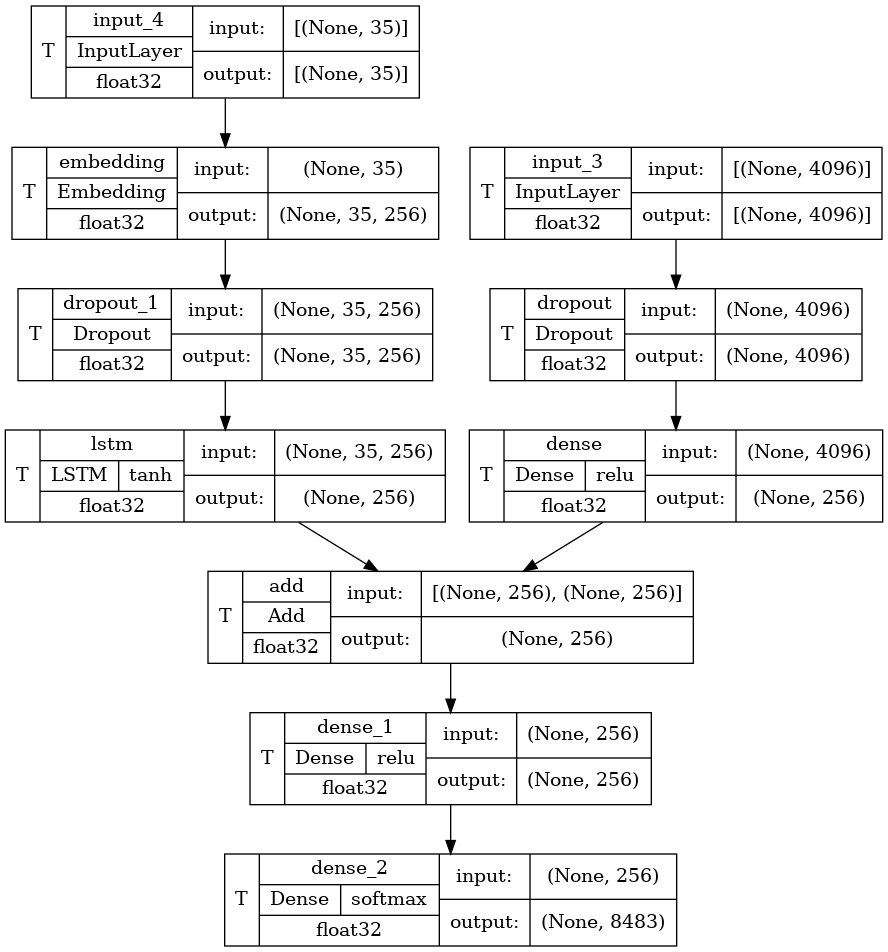

In [89]:
'''ENCODER model'''
# Image Feature layers
inputs1 = Input(shape=(4096, )) #output of VGG model
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1) # output 

# Sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) # as we are padding, use 'mask_zero
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


'''DECODER model'''
decoder1 = add([fe2, se3]) # concatenating the features
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


model = Model(inputs = [inputs1, inputs2],
              outputs = outputs)

model.compile(loss='categorical_crossentropy',
              optimizer='adam')

# Plotting the model
plot_model(model, show_dtype=True, show_layer_activations=True, show_shapes=True,
           show_trainable=True)


In [ ]:
epochs = 100
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, 
              verbose=1)

In [90]:
model.save(WORKING_DIR + '/model.h5')

/home/jerlshin/env_ai/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Generate captions for the image

In [ ]:
def idx_to_word